<a href="https://colab.research.google.com/github/willianrocha/bootcamp-datascience-alura/blob/main/module_5/ds_mod5_lecture5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


dados = pd.read_excel('https://github.com/willianrocha/bootcamp-datascience-alura/blob/main/files/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [2]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
# dados_limpos.describe()
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes

np.random.seed(73246)

x_columns = dados_limpos.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [3]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

In [4]:
modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

prob_arvore = modelo_arvore.predict_proba(x_test)
auc = roc_auc_score(y_test, prob_arvore[:,1])
print(classification_report(y_test, predicao_arvore))
auc

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



0.6543850544888428

In [5]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeat):
  np.random.seed(73246)
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  y = dados['ICU']
  x = dados[x_columns].drop(['ICU', 'WINDOW'], axis=1)

  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeat)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])
  
  # print(f'AUC teste: {auc_medio}')
  # print(f'AUC STD: {auc_std}')
  # print(f'Intervalo: {auc_medio + 2*auc_std} - {auc_medio - 2*auc_std}')

  print(f'AUC: {auc_medio} - {auc_medio_treino}')
  return auc_medio, auc_medio_treino

# roda_modelo_cv(modelo, dados_limpos, 5, 10)

In [6]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC: 0.6272705181257813 - 1.0


(0.6272705181257813, 1.0)

In [36]:
treino_lista_dtc = []
teste_lista_dtc = []
for i in range(1, 11):
  modelo_arvore = DecisionTreeClassifier(max_depth=i)
  treino, teste = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  treino_lista_dtc.append(treino)
  teste_lista_dtc.append(teste)

AUC: 0.5714767743221691 - 0.6467809984410264
AUC: 0.6764132478770637 - 0.7551194277234502
AUC: 0.6770061142182853 - 0.8266729237273652
AUC: 0.6706501088408983 - 0.8878961757509917
AUC: 0.65039815832579 - 0.9313492035102182
AUC: 0.6223535901331954 - 0.9596133498089506
AUC: 0.6012742938812018 - 0.9753302254832115
AUC: 0.5910556893616105 - 0.9852005324446413
AUC: 0.598543700698306 - 0.9909437409983448
AUC: 0.6057504364412258 - 0.9942859730291634


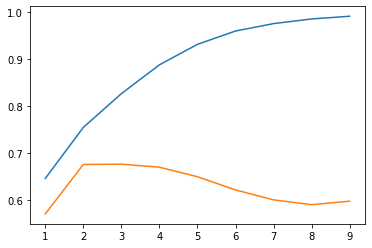

In [22]:
x = range(1, 10)
plt.plot(x, teste_lista_dtc)
plt.plot(x, treino_lista_dtc)

In [37]:
from sklearn.ensemble import RandomForestClassifier

treino_lista_rfc = []
teste_lista_rfc = []
for i in range(1, 11):
  modelo_arvore = RandomForestClassifier(max_depth=i)
  treino, teste = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  treino_lista_rfc.append(treino)
  teste_lista_rfc.append(teste)

AUC: 0.7743204987283936 - 0.852356720001015
AUC: 0.7888561872278976 - 0.8958987055525209
AUC: 0.7937720914694598 - 0.9381655918747532
AUC: 0.7974653002284582 - 0.9699973493662486
AUC: 0.7965249579723265 - 0.9874177900336621
AUC: 0.7973946075261864 - 0.9957400007306729
AUC: 0.7976098915901546 - 0.9990315150800047
AUC: 0.7966460838829259 - 0.9998681259180742
AUC: 0.7989937470365104 - 0.9999858109251772
AUC: 0.7975868908681408 - 0.9999959447140521


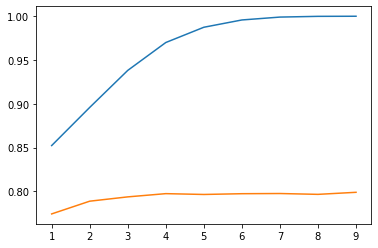

In [24]:
x = range(1, 10)
plt.plot(x, teste_lista_rfc)
plt.plot(x, treino_lista_rfc)

In [11]:
modelo_arvore = RandomForestClassifier(n_estimators=10)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)



AUC: 0.7385066436053279 - 0.9994069901453302


(0.7385066436053279, 0.9994069901453302)

In [12]:
modelo_arvore = RandomForestClassifier(n_estimators=40, max_depth=3)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC: 0.7836968996508472 - 0.9337635488149897


(0.7836968996508472, 0.9337635488149897)

In [56]:
modelo_arvore = RandomForestClassifier(n_estimators=200)
modelo_arvore.fit(x_train, y_train)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC: 0.7915283929264194 - 1.0


(0.7915283929264194, 1.0)

# Desafio

Desafio 10: Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic).

Desafio 12: Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários hiperparâmetros.

## Desafio 09: Deixar o gráfico de AUC bonitão.

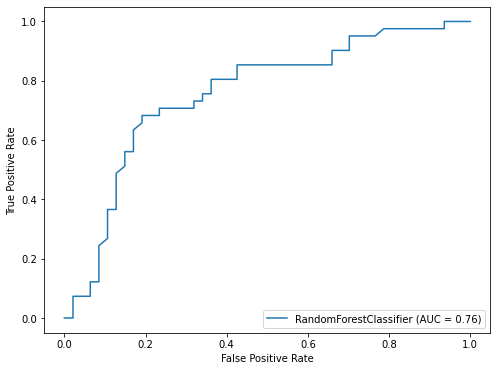

In [57]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

plot_roc_curve(modelo_arvore, x_test, y_test, ax=ax)
# plot_roc_curve(modelo_arvore, x_train, y_train, ax=ax)

Text(0.5, 0.98, 'AUC comparisson')

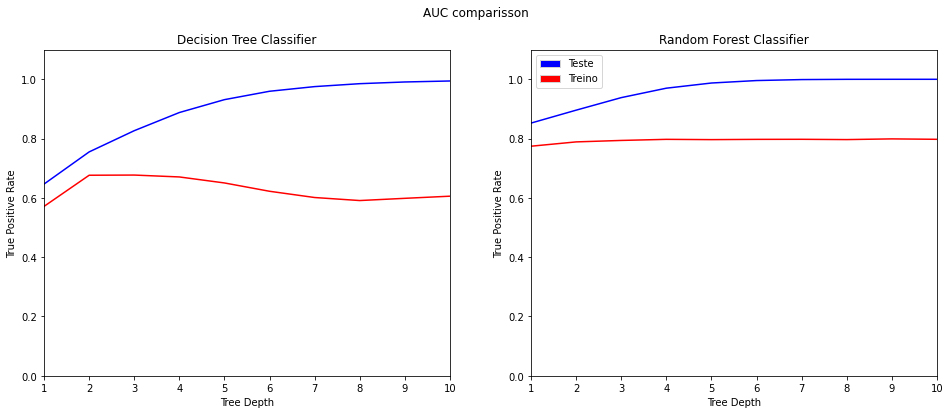

In [54]:
import matplotlib.patches as mpatches

tree_depth = range(1, 11)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharex=True)

plt.sca(ax1)
plt.plot(tree_depth, teste_lista_dtc, color='b')
plt.plot(tree_depth, treino_lista_dtc, color='r')
ax1.set_title("Decision Tree Classifier")
ax1.set_ylabel("True Positive Rate")
ax1.set_xlabel("Tree Depth")
ax1.set_ylim(0, 1.1)
ax1.set_xlim(1, 10)

plt.sca(ax2)
plt.plot(tree_depth, teste_lista_rfc, color='b')
plt.plot(tree_depth, treino_lista_rfc, color='r')
ax2.set_title("Random Forest Classifier")
ax2.set_ylabel("True Positive Rate")
ax2.set_xlabel("Tree Depth")
ax2.set_ylim(0, 1.1)

color = ['b', 'r']
label = ['Teste', 'Treino']
patches = [mpatches.Patch(facecolor=c, edgecolor='lightgray', label=l) for c, l in zip(color, label)]
plt.legend(handles=patches)#, loc=loc, bbox_to_anchor=bbox,
              #  frameon=frame, labelcolor=GRAY5, title=suptitle_formatter(title))
fig.suptitle("AUC comparisson")

## Desafio 11: Estudar um pouco mais sobre overfit e underfit.

https://medium.com/@itbodhi/overfitting-and-underfitting-in-machine-learning-models-76cb60dbdaf6

## Desafio 13: Pesquisar como salvar um modelo treinado.

In [58]:
import pickle

In [69]:
with open('dct_200.model', mode='w+b')as model_file:
  s = pickle.dump(modelo_arvore, model_file)

In [73]:
with open('dct_200.model', mode='r+b')as model_file:
  modelo_arvore_unpickled = pickle.load(model_file)
modelo_arvore_unpickled

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [77]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC: 0.7915283929264194 - 1.0


(0.7915283929264194, 1.0)

In [78]:
roda_modelo_cv(modelo_arvore_unpickled, dados_limpos, 5, 10)

AUC: 0.7915283929264194 - 1.0


(0.7915283929264194, 1.0)